# VGG16 example for Menoh Haskell

We'll show how you can import ONNX models into Menoh, and use the imported model for inference.

First let's import some modules and also check the version of Menoh itself and its Haskell binding.

In [1]:
{-# LANGUAGE ScopedTypeVariables #-}
import Control.Applicative
import Control.Monad
import System.FilePath
import Text.Printf
import Menoh

In [2]:
Menoh.version

Version {versionBranch = [1,0,2], versionTags = []}

In [3]:
Menoh.bindingVersion

Version {versionBranch = [0,2,0], versionTags = []}

## Step 1: Prepare ONNX model and sample input image

In this example, we will demonstrate importing a VGG16 model, a model for image classification. The model was converted to ONNX using [onnx-chainer](https://github.com/chainer/onnx-chainer) from [Chainer](https://chainer.org/)'s [VGG16Layers](https://docs.chainer.org/en/stable/reference/generated/chainer.links.VGG16Layers.html).

First we need to download the pre-trained model file and class definition file and sample input image.

In [4]:
dataDir = "data"

In [5]:
import Control.Monad.Trans.Resource
import Data.Conduit.Binary (sinkFile)
import Network.HTTP.Simple
import System.Directory

downloadTo :: String -> FilePath -> IO ()
downloadTo req fname = do
  b <- doesFileExist fname
  unless b $ do
    putStrLn $ req ++ " -> " ++ fname
    request <- parseRequest req
    runResourceT $ httpSink request $ \_ -> sinkFile fname

In [6]:
downloadTo "https://www.dropbox.com/s/bjfn9kehukpbmcm/VGG16.onnx?dl=1" $ dataDir </> "VGG16.onnx"
downloadTo "https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt" $ dataDir </> "synset_words.txt"
downloadTo "https://upload.wikimedia.org/wikipedia/commons/5/54/Light_sussex_hen.jpg" $ dataDir </> "Light_sussex_hen.jpg"

https://www.dropbox.com/s/bjfn9kehukpbmcm/VGG16.onnx?dl=1 -> data/VGG16.onnx

https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt -> data/synset_words.txt

https://upload.wikimedia.org/wikipedia/commons/5/54/Light_sussex_hen.jpg -> data/Light_sussex_hen.jpg

## Step 2: Loading ONNX model

Now that we have downloaded an ONNX model file, let's load the model data into Menoh. The `model_data` contains computation graph structure and weights of layers.

In [7]:
-- Load ONNX model data
model_data <- makeModelDataFromONNX (dataDir </> "VGG16.onnx")

Then we specify its input and output:

In [8]:
batch_size  = 1
channel_num = 3
height = 224
width  = 224
category_num = 1000

input_dims, output_dims :: Dims
input_dims  = [batch_size, channel_num, height, width]
output_dims = [batch_size, category_num]

-- Aliases to onnx's node input and output tensor name
conv1_1_in_name  = "140326425860192"
fc6_out_name     = "140326200777584"
softmax_out_name = "140326200803680"

In [9]:
-- Specify inputs and outputs
vpt <- makeVariableProfileTable
         [(conv1_1_in_name, DTypeFloat, input_dims)]
         [(fc6_out_name, DTypeFloat), (softmax_out_name, DTypeFloat)]
         model_data
optimizeModelData model_data vpt

Having specified inputs and outputs, we construct a model for inference specifying  MKL-DNN as backend.

In [10]:
-- Construct computation primitive list and memories
model <- makeModel vpt model_data "mkldnn"

##  Step 3: Prepare input for inference

Next, we prepare an input image for inference.

In [11]:
import qualified Codec.Picture as Picture

In [12]:
image <- do
  ret <- Picture.readImage $ dataDir </> "Light_sussex_hen.jpg"
  case ret of
    Left e -> error e
    Right img -> return $ Picture.convertRGB8 img

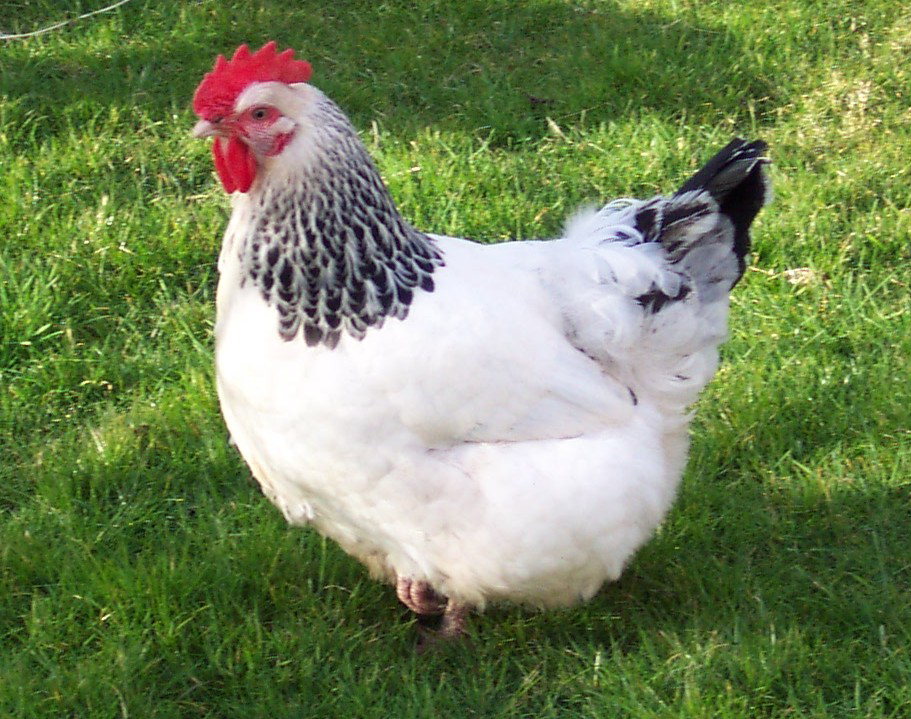

In [13]:
image

Then we define `convert` function to convert the image into a format for the VGG16 model, namely 244x244 floating point image in NCHW format with BGR channel ordering.

In [14]:
import qualified Codec.Picture as Picture
import qualified Data.Vector as V
import qualified Data.Vector.Storable as VS

convert :: Int -> Int -> Picture.Image Picture.PixelRGB8 -> VS.Vector Float
convert w h = reorderToNCHW . resize (w,h) . crop

crop :: Picture.Pixel a => Picture.Image a -> Picture.Image a
crop img = Picture.generateImage (\x y -> Picture.pixelAt img (base_x + x) (base_y + y)) shortEdge shortEdge
  where
    shortEdge = min (Picture.imageWidth img) (Picture.imageHeight img)
    base_x = (Picture.imageWidth  img - shortEdge) `div` 2
    base_y = (Picture.imageHeight img - shortEdge) `div` 2

-- TODO: Should we do some kind of interpolation?
resize :: Picture.Pixel a => (Int,Int) -> Picture.Image a -> Picture.Image a
resize (w,h) img = Picture.generateImage (\x y -> Picture.pixelAt img (x * orig_w `div` w) (y * orig_h `div` h)) w h
  where
    orig_w = Picture.imageWidth  img
    orig_h = Picture.imageHeight img

-- Note that VGG16.onnx assumes BGR image
reorderToNCHW :: Picture.Image Picture.PixelRGB8 -> VS.Vector Float
reorderToNCHW img = VS.generate (3 * Picture.imageHeight img * Picture.imageWidth img) f
  where
    f i =
      case Picture.pixelAt img x y of
        Picture.PixelRGB8 r g b ->
          case ch of
            0 -> fromIntegral b
            1 -> fromIntegral g
            2 -> fromIntegral r
            _ -> undefined
      where
        (ch,m) = i `divMod` (Picture.imageWidth img * Picture.imageHeight img)
        (y,x) = m `divMod` Picture.imageWidth img

## Step 3: Run inference

Now that we have prepared a Menoh inference model and input image. It's time to run an inference.

In [15]:
import Data.Word
import qualified Data.Vector.Generic as VG
import qualified Data.Vector.Storable as VS

-- Copy input image data to model's input array
writeBuffer model conv1_1_in_name [convert width height image]

-- Run inference
run model

-- Get output
([fc6_out] :: [VS.Vector Float]) <- readBuffer model fc6_out_name
([softmax_out] :: [VS.Vector Float]) <- readBuffer model softmax_out_name

## Step 4: Examine the results

Finally, let's examine the results.

In [16]:
import Data.List
import Data.Ord

categories <- fmap lines $ readFile $ dataDir </> "synset_words.txt"
let k = 5
scores <- forM [0 .. VG.length softmax_out - 1] $ \i ->
  return (i, softmax_out VG.! i)
printf "top %d categories are:\n" k
forM_ (take k $ sortBy (flip (comparing snd)) scores) $ \(i,p) ->
  printf "%0.1f%%: %s\n" (p * 100) (categories !! i)

top 5 categories are:

95.8%: n01514859 hen
4.0%: n01514668 cock
0.2%: n01807496 partridge
0.0%: n01797886 ruffed grouse, partridge, Bonasa umbellus
0.0%: n01847000 drake

The top-ranked class is "hen" and the the second is "cock". The result looks reasonable for the image.